# Map 3 - Unconformity

This map is from Bennison et al. (2011). Like map 2, this map also has an unconformity.

In [5]:
# Import plotting libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

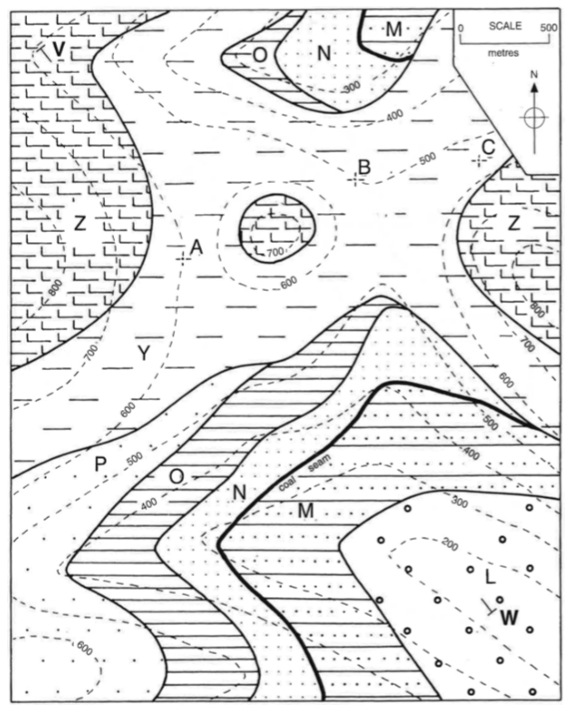

In [6]:
# Display map
img = mpimg.imread('map3.png')
plt.figure(figsize=(10,10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.tight_layout()

In [7]:
# Import other required libraries
import geopandas as gpd
import rasterio
import gemgis as gg
import os

In [8]:
# Get current directory
current_directory = os.getcwd()

In [9]:
# Read the topographic contours
topo = gpd.read_file(filename = current_directory+"/contours/contours.shp")
topo.head()

,X,Y,Z,geometry
0,3069.86,94.40,200,POINT (3069.858 94.400)
1,3023.48,125.53,200,POINT (3023.482 125.527)
2,3000.74,148.50,200,POINT (3000.745 148.496)
3,2972.87,174.05,200,POINT (2972.874 174.046)
4,2934.09,201.61,200,POINT (2934.095 201.612)


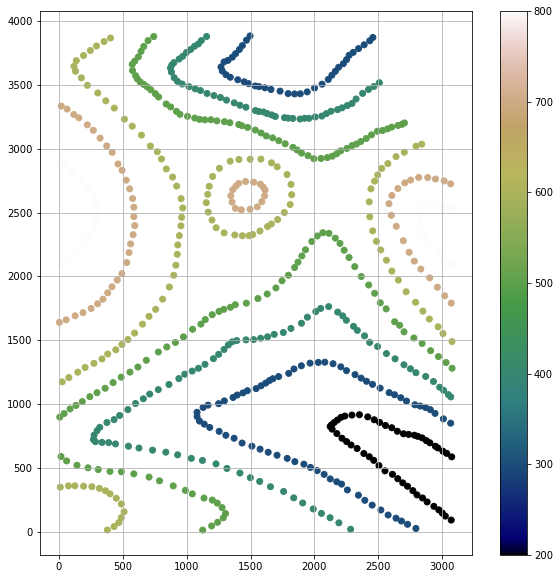

In [10]:
# Plot the contours
fix, ax = plt.subplots(1, figsize=(10, 10))
topo.plot(ax=ax,aspect='equal',column='Z', cmap='gist_earth', legend=True)
plt.grid()

In [11]:
# Interpolate contour lines to make DEM
topo_raster = gg.vector.interpolate_raster(gdf=topo,value='Z',method='rbf',res=5)

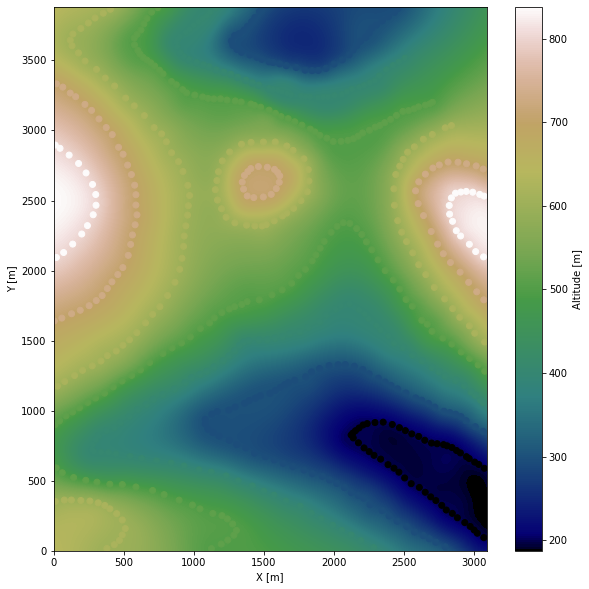

In [12]:
# Plot the DEM
fix, ax = plt.subplots(1, figsize=(10, 10))
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = plt.imshow(topo_raster, origin='lower', extent=[0, 3090, 0, 3880], cmap='gist_earth')
cbar = plt.colorbar(im)
cbar.set_label('Altitude [m]')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]');

In [13]:
# Save the DEM as a tif file
gg.raster.save_as_tiff(raster=topo_raster, path='dem_map3.tif', 
                       extent=[0, 3090, 0, 3880], crs='EPSG:4326', overwrite_file=True)

Raster successfully saved


In [14]:
# Open the DEM from tif file
topo_raster = rasterio.open('dem_map3.tif')

In [15]:
# Read the contacts. These are the bases of the units
contacts = gpd.read_file(current_directory+'/contacts/contacts.shp')
contacts.head()

,X,Y,formation,geometry
0,868.46,156.18,P,POINT (868.460 156.184)
1,478.23,985.51,P,POINT (478.227 985.507)
2,1100.96,1584.28,P,POINT (1100.963 1584.277)
3,1347.14,301.74,O,POINT (1347.138 301.740)
4,998.15,1070.69,O,POINT (998.148 1070.693)


In [16]:
# Extract the Z coordinate of the points at the contacts
contacts_with_Z = gg.vector.extract_xyz(gdf=contacts, dem=topo_raster)
contacts_with_Z

,X,Y,formation,geometry,Z
0,868.46,156.18,P,POINT (868.460 156.184),537.22
1,478.23,985.51,P,POINT (478.227 985.507),418.81
2,1100.96,1584.28,P,POINT (1100.963 1584.277),495.28
3,1347.14,301.74,O,POINT (1347.138 301.740),468.92
4,998.15,1070.69,O,POINT (998.148 1070.693),344.60
5,1860.33,1804.28,O,POINT (1860.327 1804.279),441.19
6,1512.90,3563.58,O,POINT (1512.897 3563.581),280.53
7,1646.72,299.08,N,POINT (1646.724 299.083),417.38
8,1333.95,1095.53,N,POINT (1333.955 1095.527),304.43
9,2476.07,1723.28,N,POINT (2476.066 1723.276),465.28


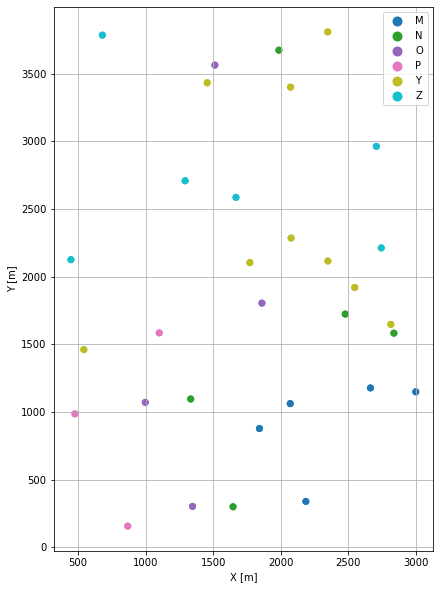

In [17]:
# Plot the points on the contacts
fig, ax = plt.subplots(1, figsize=(10, 10))
contacts.plot(ax=ax, column='formation', legend=True, aspect='equal')
contacts_with_Z.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]');

In [18]:
# Read the strike lines at the base of N, P and Y
gdf_N = gpd.read_file(current_directory+'/strike_lines/strike_lines_N.shp')
gdf_P = gpd.read_file(current_directory+'/strike_lines/strike_lines_P.shp')
gdf_Y = gpd.read_file(current_directory+'/strike_lines/strike_lines_Y.shp')
gdf_N

,X,Y,Z,formation,id,geometry
0,1192.68,815.64,300,N,3,POINT (1192.681 815.644)
1,1261.80,1012.34,300,N,3,POINT (1261.795 1012.338)
2,2068.91,1768.59,400,N,4,POINT (2068.908 1768.592)
3,1595.93,383.99,400,N,4,POINT (1595.928 383.986)


In [19]:
# Convert the points into strike lines
linestring_gdf_N = gg.vector.create_linestring_gdf(gdf=gdf_N)
linestring_gdf_P = gg.vector.create_linestring_gdf(gdf=gdf_P)
linestring_gdf_Y = gg.vector.create_linestring_gdf(gdf=gdf_Y)
linestring_gdf_Y

,index,X,Y,Z,formation,id,geometry
0,0,1932.66,2211.18,500,Y,1,"LINESTRING (1932.656 2211.178, 2234.893 2209.633)"
1,2,467.92,1440.66,600,Y,2,"LINESTRING (467.921 1440.661, 3100.174 1463.140)"


In [20]:
# Check that the strike lines are valid
linestring_gdf_N.is_valid

0    True
1    True
dtype: bool

In [21]:
linestring_gdf_P.is_valid

0    True
1    True
dtype: bool

In [22]:
linestring_gdf_Y.is_valid

0    True
1    True
dtype: bool

In [23]:
# Calculate the orientation of the bases of N, P and Y from the strike lines
orientations_N = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_N)
orientations_P = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_P)
orientations_Y = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_Y)
orientations_N

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,10.90,288.87,350.00,POINT (1529.828 995.140),1.00,1529.83,995.14,N


In [24]:
orientations_P

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,11.28,289.72,450.00,POINT (672.577 922.414),1.00,672.58,922.41,P


In [25]:
orientations_Y

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,7.56,359.52,550.00,POINT (1933.911 1831.153),1.00,1933.91,1831.15,Y


The base of N and the base of P dip 11 degrees to the NW. The base of Y on the other hand dips 7 degrees to the North. The base of Y is an unconformity.  Y and Z lie unconformably over L-P.

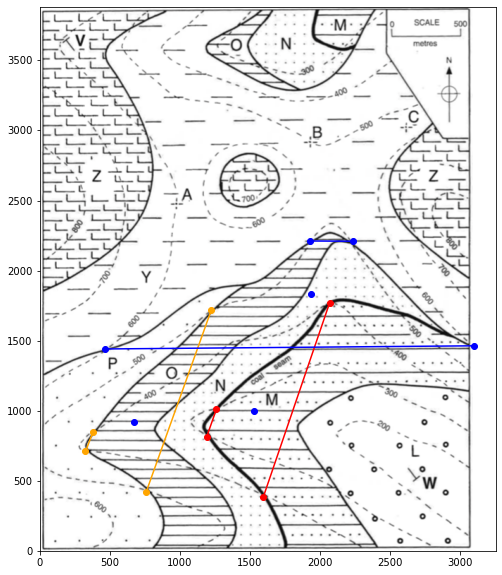

In [26]:
# Plot all this information on the map, the blue dots are orientations
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img, extent=[0, 3090, 0, 3880], cmap='gray')
# base N
gdf_N.plot(ax=ax, aspect='equal', color='red')
linestring_gdf_N.plot(ax=ax, aspect='equal', color='red')
orientations_N.plot(ax=ax, aspect='equal', color='blue')
# base P
gdf_P.plot(ax=ax, aspect='equal', color='orange')
linestring_gdf_P.plot(ax=ax, aspect='equal', color='orange')
orientations_P.plot(ax=ax, aspect='equal', color='blue')
# base Y
gdf_Y.plot(ax=ax, aspect='equal', color='blue')
linestring_gdf_Y.plot(ax=ax, aspect='equal', color='blue')
orientations_Y.plot(ax=ax, aspect='equal', color='blue');

In [27]:
# Merge orientations
import pandas as pd
orientations = pd.concat([orientations_N, orientations_P,orientations_Y]).reset_index()
orientations

,index,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,0,10.90,288.87,350.00,POINT (1529.828 995.140),1.00,1529.83,995.14,N
1,0,11.28,289.72,450.00,POINT (672.577 922.414),1.00,672.58,922.41,P
2,0,7.56,359.52,550.00,POINT (1933.911 1831.153),1.00,1933.91,1831.15,Y


# Construction of the model in GemPy

In [28]:
# Import Gempy
import gempy as gp

In [29]:
# Create a geomodel object called model3
geo_model = gp.create_model('model3')

In [30]:
# Define model extent, resolution, surface points, and orientations
gp.init_data(geo_model, [0, 3090, 0, 3880, 0, 1200], [100, 100, 100],
             surface_points_df=contacts_with_Z,
             orientations_df=orientations, default_values=True);

Active grids: ['regular']


In [31]:
# Check default series. We need to create 2 different series 
# for the units below and above the unconformity
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,P,Default series,1,#015482,1
1,O,Default series,2,#9f0052,2
2,N,Default series,3,#ffbe00,3
3,M,Default series,4,#728f02,4
4,Z,Default series,5,#443988,5
5,Y,Default series,6,#ff3f20,6


In [32]:
# The base of the lowermost unit L does not outcrop in the map
# This unit is our "basement", we add it manually
geo_model.add_surfaces('L')

# The units are divided into 2 series
# Strata1 = units above the unconformity
# Strata2 = units below the unconformity
gp.map_stack_to_surfaces(geo_model, {'Strata1': ('Z', 'Y'), 'Strata2': ('P', 'O', 'N', 'M','L'),},
                         remove_unused_series=True)

,surface,series,order_surfaces,color,id
4,Z,Strata1,1,#443988,1
5,Y,Strata1,2,#ff3f20,2
0,P,Strata2,1,#015482,3
1,O,Strata2,2,#9f0052,4
2,N,Strata2,3,#ffbe00,5
3,M,Strata2,4,#728f02,6
6,L,Strata2,5,#5DA629,7


In [33]:
# Check that the data are correct
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,color,id,No. of Interfaces,No. of Orientations
4,Z,Strata1,1,#443988,1,6,0
5,Y,Strata1,2,#ff3f20,2,9,1
0,P,Strata2,1,#015482,3,3,1
1,O,Strata2,2,#9f0052,4,4,0
2,N,Strata2,3,#ffbe00,5,5,1
3,M,Strata2,4,#728f02,6,5,0
6,L,Strata2,5,#5DA629,7,0,0


In [34]:
# Set the topography of the model
geo_model.set_topography(source='gdal',filepath='dem_map3.tif');

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


In [35]:
# Plot the points on the contacts and topography in 3D 
# This will open a PyVista window. This may take some time, please wait
from pyvistaqt import BackgroundPlotter
gp.plot_3d(geo_model, plotter_type='background',show_topography=True);

In [36]:
# Now we have enough data to interpolate. This may take some time, please wait
gp.set_interpolator(geo_model, compile_theano=True, 
                    theano_optimizer='fast_compile');

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                    values
range             5103.19
$C_o$           620059.52
drift equations    [3, 3]


In [37]:
# Ignore warnings from np
import warnings
import numpy as np
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Compute the geological model. This may take some time, please wait
gp.compute_model(geo_model);

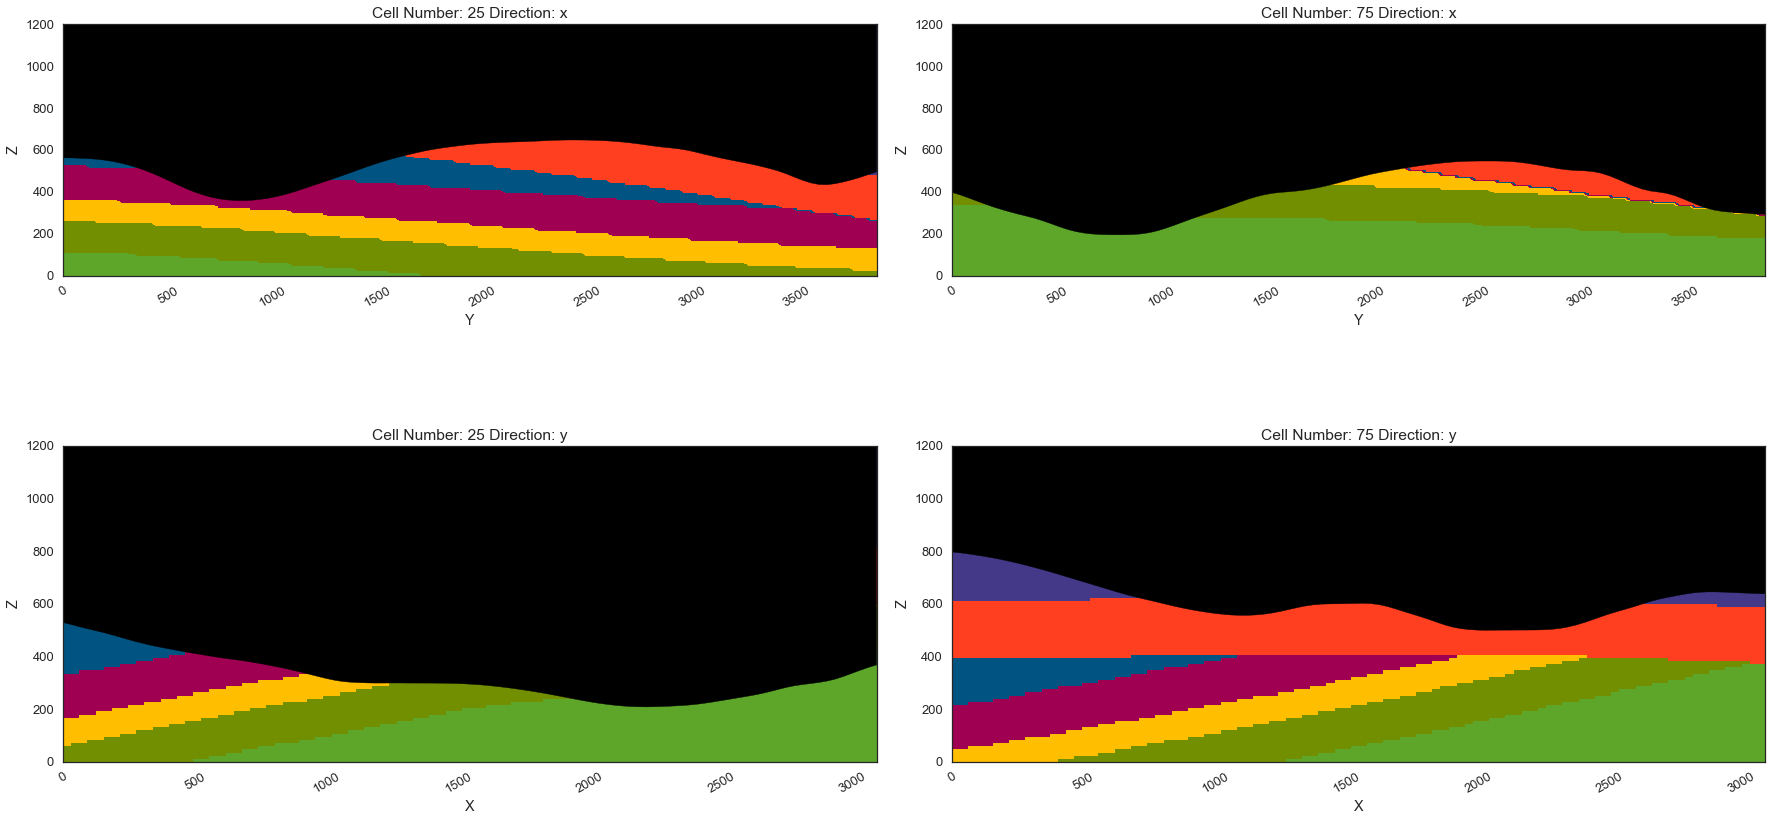

In [38]:
# Plot north-south and east-west sections without vertical exaggeration
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25, 75, 25, 75], 
           show_data=False,show_boundaries=False, show_topography=True, show=False);

In [39]:
# Plot the geomodel in 3D, this will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type='background', show_topography=True, show_lith=False);